In [1]:
#3. Identify the communities of the network using k-plex algorithm as implemented in
#Networkx. Use appropriate visualization tools to display a dense representation of these
#communities.

#How to visualize large graph with thousands of nodes?
#The idea is not to visualize all the nodes of the network on the same page and copy and past this on your report, 
#that is not interesting and not doable as we want to highlight the main components and interesting nodes of the network. 
#You can screw up, down, left and right to identify this when using basic NetworkX plot.  Alternatively, you may use more advanced 
#graph library that you can import to your networkX. For instance, Graphviz, PyGraphvis, pydot, can provide some more interesting 
#visualization that highlights such interesting components and nodes.. 

#How to use k-plex in NetworkX?
#k-plex is not directly implemented in NetowrkX
#You can look at alternative existing implementations elsewhere.. For instance in https://github.com/bachsh/kplex/blob/master/tests.py  (need to check if it is updated)- or another source
#You can also make some program on your own.. For instance you can start by identifying the largest component in the graph, 
#say V, and the smallest degree d of all nodes of V, then the k-value (in k-plex) whose outcome will be the subgraph V is |V|-d.  
#You can proceed by exploring other components in the graph and identify the corresponding value of k accordingly as previously.. 
#Check for specific value of k, the result should be associated to the largest set (subgraph).. 


In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import cm

In [2]:
graph_df = pd.read_csv("data/soc-sign-bitcoinalpha.csv", header=None)
graph_df.columns = ["source", "target", "weight", "time"]
G = nx.from_pandas_edgelist(graph_df, source="source", target="target", edge_attr="weight", create_using=nx.DiGraph)
graph_df
#Potentially come back to make an excel file/draw the graph


,source,target,weight,time
0,7188,1,10,1407470400
1,430,1,10,1376539200
2,3134,1,10,1369713600
3,3026,1,10,1350014400
4,3010,1,10,1347854400
...,...,...,...,...
24181,7604,7601,10,1364270400
24182,7601,7604,10,1364270400
24183,7604,7602,10,1364270400
24184,7602,7604,10,1364270400


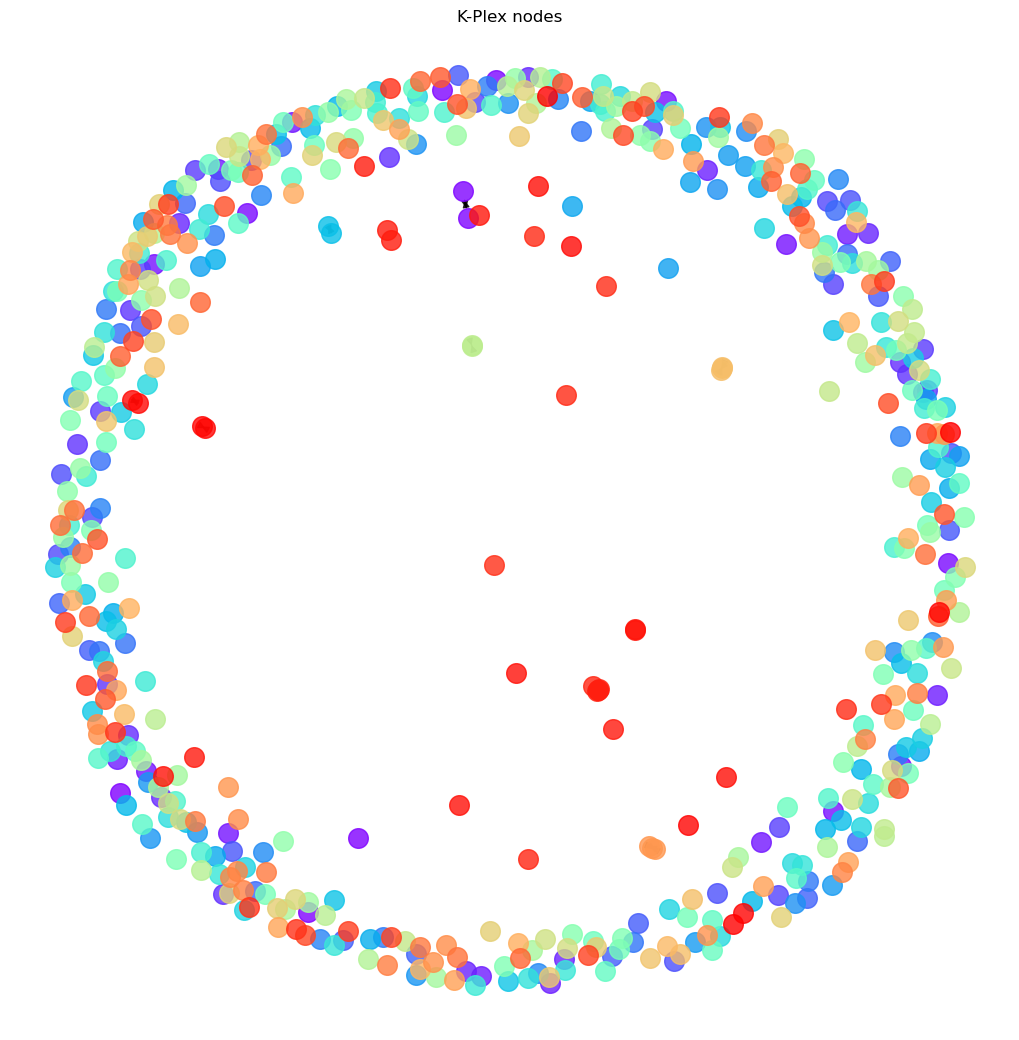

In [6]:
# PART C, directed k-plex graph/s
# Can be ran multiple times for different pooling
def analyze_k_plexes(G, iterations):

    # Largest strongly connected component
    def largest_strongly_connected_component(graph):
        components = list(nx.strongly_connected_components(graph))
        largest_component = max(components, key=len)
        return graph.subgraph(largest_component)

    # Calculate k-value based on the minimum degree
    def calculate_k(subgraph):
        min_degree = min(dict(subgraph.degree()).values())
        k = max(1, min(len(subgraph) - min_degree, len(subgraph) // 2))
        return k

    # Find k-plexes in the directed graph
    def find_k_plex(graph, k):
        components = list(nx.strongly_connected_components(graph))
        k_plexes = []

        for component in components:
            subgraph = graph.subgraph(component)
            if all(degree >= (len(subgraph) - k) for _, degree in subgraph.degree()):
                k_plexes.append(subgraph)

        return k_plexes

    # Plot k-plexes
    def plot_k_plexes(graph, k_plexes, iteration):
        pos = nx.spring_layout(graph)  # Layout
        plt.figure(figsize=(10, 10))

        colors = plt.cm.rainbow(np.linspace(0, 1, len(k_plexes)))
        for color, k_plex in zip(colors, k_plexes):
            nx.draw(k_plex, pos, node_color=color, edge_color='black', alpha=0.8, node_size=200)

        plt.title(f"K-Plex nodes")
        plt.savefig("plots/C_k_plex_communities.pdf")
        plt.show()

    # For additional iterations
    all_k_plexes = []
    for i in range(1, iterations + 1):
        largest_component = largest_strongly_connected_component(G)
        k = calculate_k(largest_component)
        k_plexes = find_k_plex(G, k)
        plot_k_plexes(G, k_plexes, i)
        all_k_plexes.append((k, k_plexes))

    return all_k_plexes

#---------------------------------
#Function call
all_k_plexes = analyze_k_plexes(G, iterations=1)

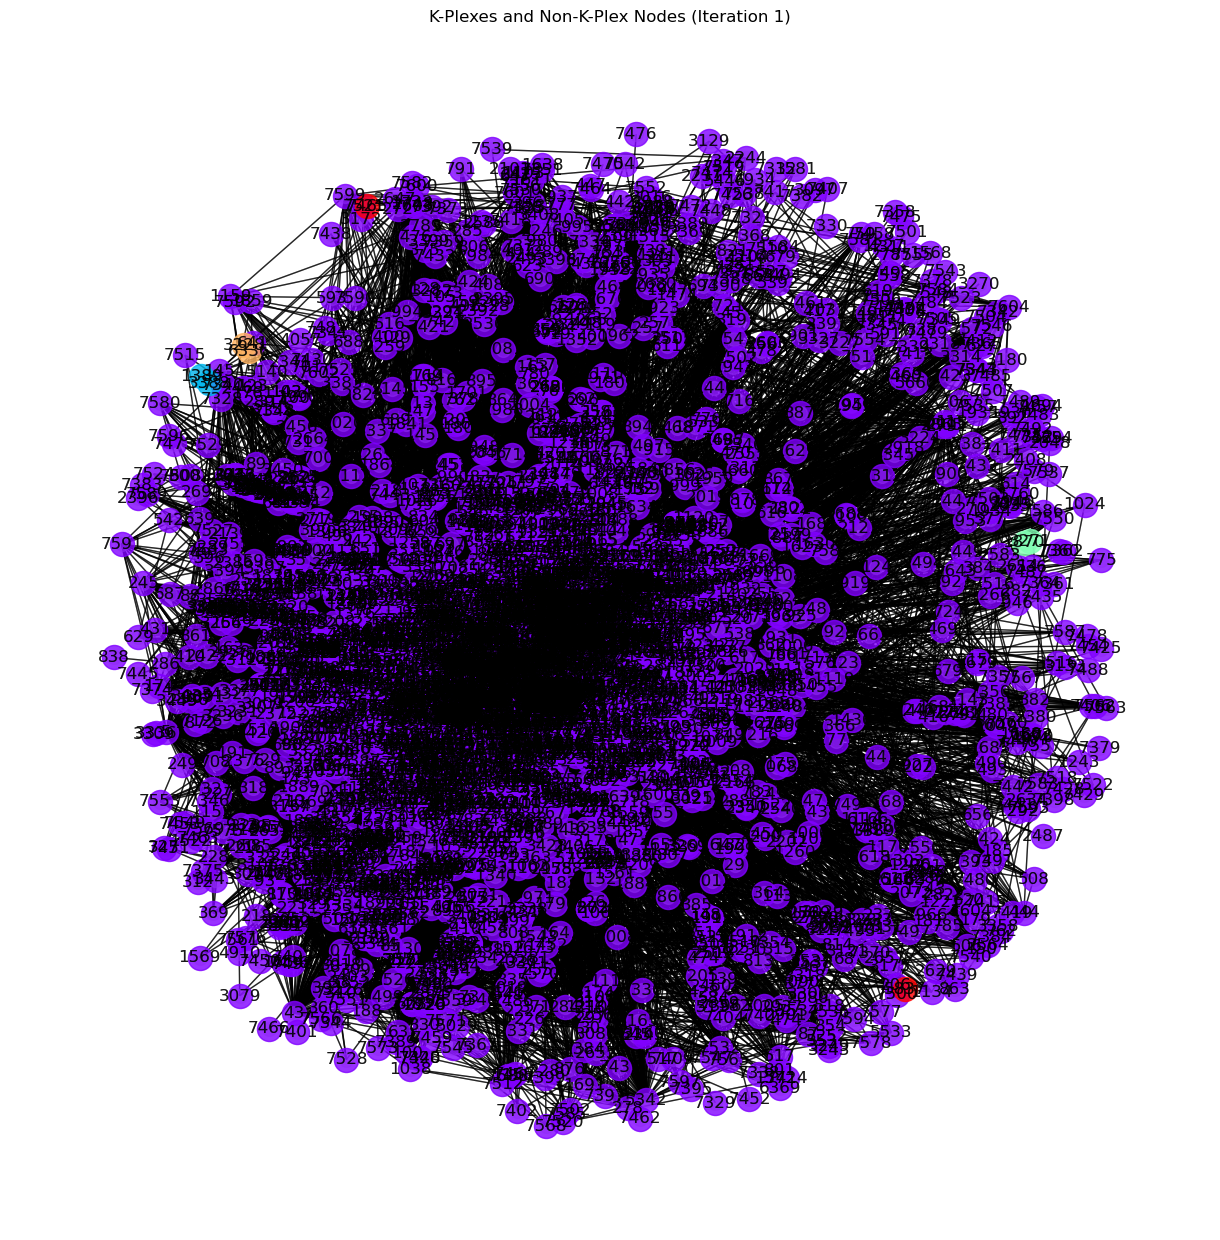

In [5]:
# Part C, k-plex for undirected graph
# Function to analyze and plot k-plex communities with pooling and multiple iterations
def analyze_and_plot_k_plex_with_pooling(graph, iterations=1):
    # Ensure the graph is undirected
    graph = graph.to_undirected()

    # Function to find the largest connected component in a graph
    def largest_connected_component(graph):
        components = list(nx.connected_components(graph))
        largest_component = max(components, key=len)
        return graph.subgraph(largest_component)

    # Function to determine k-value with a higher floor
    def calculate_k(subgraph):
        min_degree = min(subgraph.degree(), key=lambda x: x[1])[1]
        k_floor = 5  # Minimum value to ensure smaller, denser k-plexes
        return max(len(subgraph) - min_degree, k_floor)

    # Function to find k-plexes given a graph and k-value
    def find_k_plex(graph, k):
        components = list(nx.connected_components(graph))
        k_plexes = []
        for component in components:
            subgraph = graph.subgraph(component)
            if all(degree >= (len(subgraph) - k) for node, degree in subgraph.degree()):
                k_plexes.append(subgraph)
        return k_plexes

    # Function to plot k-plexes with non-k-plex nodes
    def plot_k_plexes_with_non_plexes(graph, k_plexes, iteration):
        pos = nx.spring_layout(graph)  # Use spring layout for visualization
        plt.figure(figsize=(12, 12))

        # Base graph
        nx.draw(graph, pos, node_color='lightgray', with_labels=True, node_size=100, edge_color='gray', alpha=0.5)

        # Collect all k-plex nodes
        k_plex_nodes = set()
        for k_plex in k_plexes:
            k_plex_nodes.update(k_plex.nodes())

        # Highlight k-plexes with unique colors
        colors = cm.rainbow(np.linspace(0, 1, len(k_plexes)))
        for color, k_plex in zip(colors, k_plexes):
            nx.draw(k_plex, pos, node_color=color, with_labels=True, node_size=300, edge_color='black', alpha=0.8)

        # Non-k-plex nodes
        non_plex_nodes = set(graph.nodes()) - k_plex_nodes
        nx.draw(graph.subgraph(non_plex_nodes), pos, node_color='red', with_labels=True, node_size=100, edge_color='gray', alpha=0.8)

        plt.title(f"K-Plexes and Non-K-Plex Nodes (Iteration {iteration})")
        plt.show()

    # Find the largest component and calculate the initial k-value
    largest_component = largest_connected_component(graph)
    k = calculate_k(largest_component)

    # Run multiple iterations to identify k-plexes and plot them
    for iteration in range(1, iterations + 1):
        # Find k-plexes with the calculated k-value
        k_plexes = find_k_plex(graph, k)

        # Plot k-plexes and non-k-plex nodes
        plot_k_plexes_with_non_plexes(graph, k_plexes, iteration)

        # Optionally, adjust the k value to experiment with different k-plex configurations
        k = k + 1  # Increment k to see changes in community structure

analyze_and_plot_k_plex_with_pooling(G, iterations=1)